# References
* https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb
* https://www.kaggle.com/code/kamyarazar/stock-price-prediction-lstm-hyperparameter-tuning#Fearure-Scaling
* https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm
* https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

# Installations

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, TimeDistributed, Dropout, Bidirectional, GRU
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.callbacks import EarlyStopping
import itertools
from sklearn.model_selection import cross_validate
from scipy.stats import linregress
import seaborn as sns
#import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Mounted at /content/drive


# Data exploration

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Q2_Pattern_Recognition/final_project/data/all_data.csv',sep=',', decimal='.')
df.info() # We see that we have 50 features.
#Some of them might be computed by the algebraic operation of the others, because it is a profit and loss account.
# Also wee see that except of coulumn "year" (index) and "Empresa" (string)
# How many business do we have?
bussines_number = df['Empresa'].nunique()
print(bussines_number) # We have 2159 bussines, due that between them does not have to have any correlation we will take randomly 1 of them to do the exploratory analisi.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53975 entries, 0 to 53974
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Año                                     53975 non-null  object 
 1   Acreedores a L. P.                      53975 non-null  float64
 2   Acreedores comerciales                  53975 non-null  float64
 3   Activo circulante                       53975 non-null  float64
 4   Capital suscrito                        53975 non-null  float64
 5   Cash flow                               53975 non-null  float64
 6   Consumo de mercaderías y de materias    53975 non-null  float64
 7   Deudas financieras                      53975 non-null  float64
 8   Deudores                                53975 non-null  float64
 9   Dotaciones para amortiz. de inmovil.    53975 non-null  float64
 10  EBIT                                    53975 non-null  fl

## Data exploration for 1 business



In [ ]:
empresas_unicas = df['Empresa'].unique()
seleccionadas = pd.Series(empresas_unicas).sample(n=1, random_state=3).tolist() #We select randomly one company
df_seleccionadas = df[df['Empresa'].isin(seleccionadas)]
df_seleccionadas.info()
df_seleccionadas.head()
numeric_cols = df_seleccionadas.select_dtypes(include=['float64', 'int64']).columns.drop('Año', errors='ignore')

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 13600 to 13624
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Año                                     25 non-null     object 
 1   Acreedores a L. P.                      25 non-null     float64
 2   Acreedores comerciales                  25 non-null     float64
 3   Activo circulante                       25 non-null     float64
 4   Capital suscrito                        25 non-null     float64
 5   Cash flow                               25 non-null     float64
 6   Consumo de mercaderías y de materias    25 non-null     float64
 7   Deudas financieras                      25 non-null     float64
 8   Deudores                                25 non-null     float64
 9   Dotaciones para amortiz. de inmovil.    25 non-null     float64
 10  EBIT                                    25 non-null     float6

### Heatmap

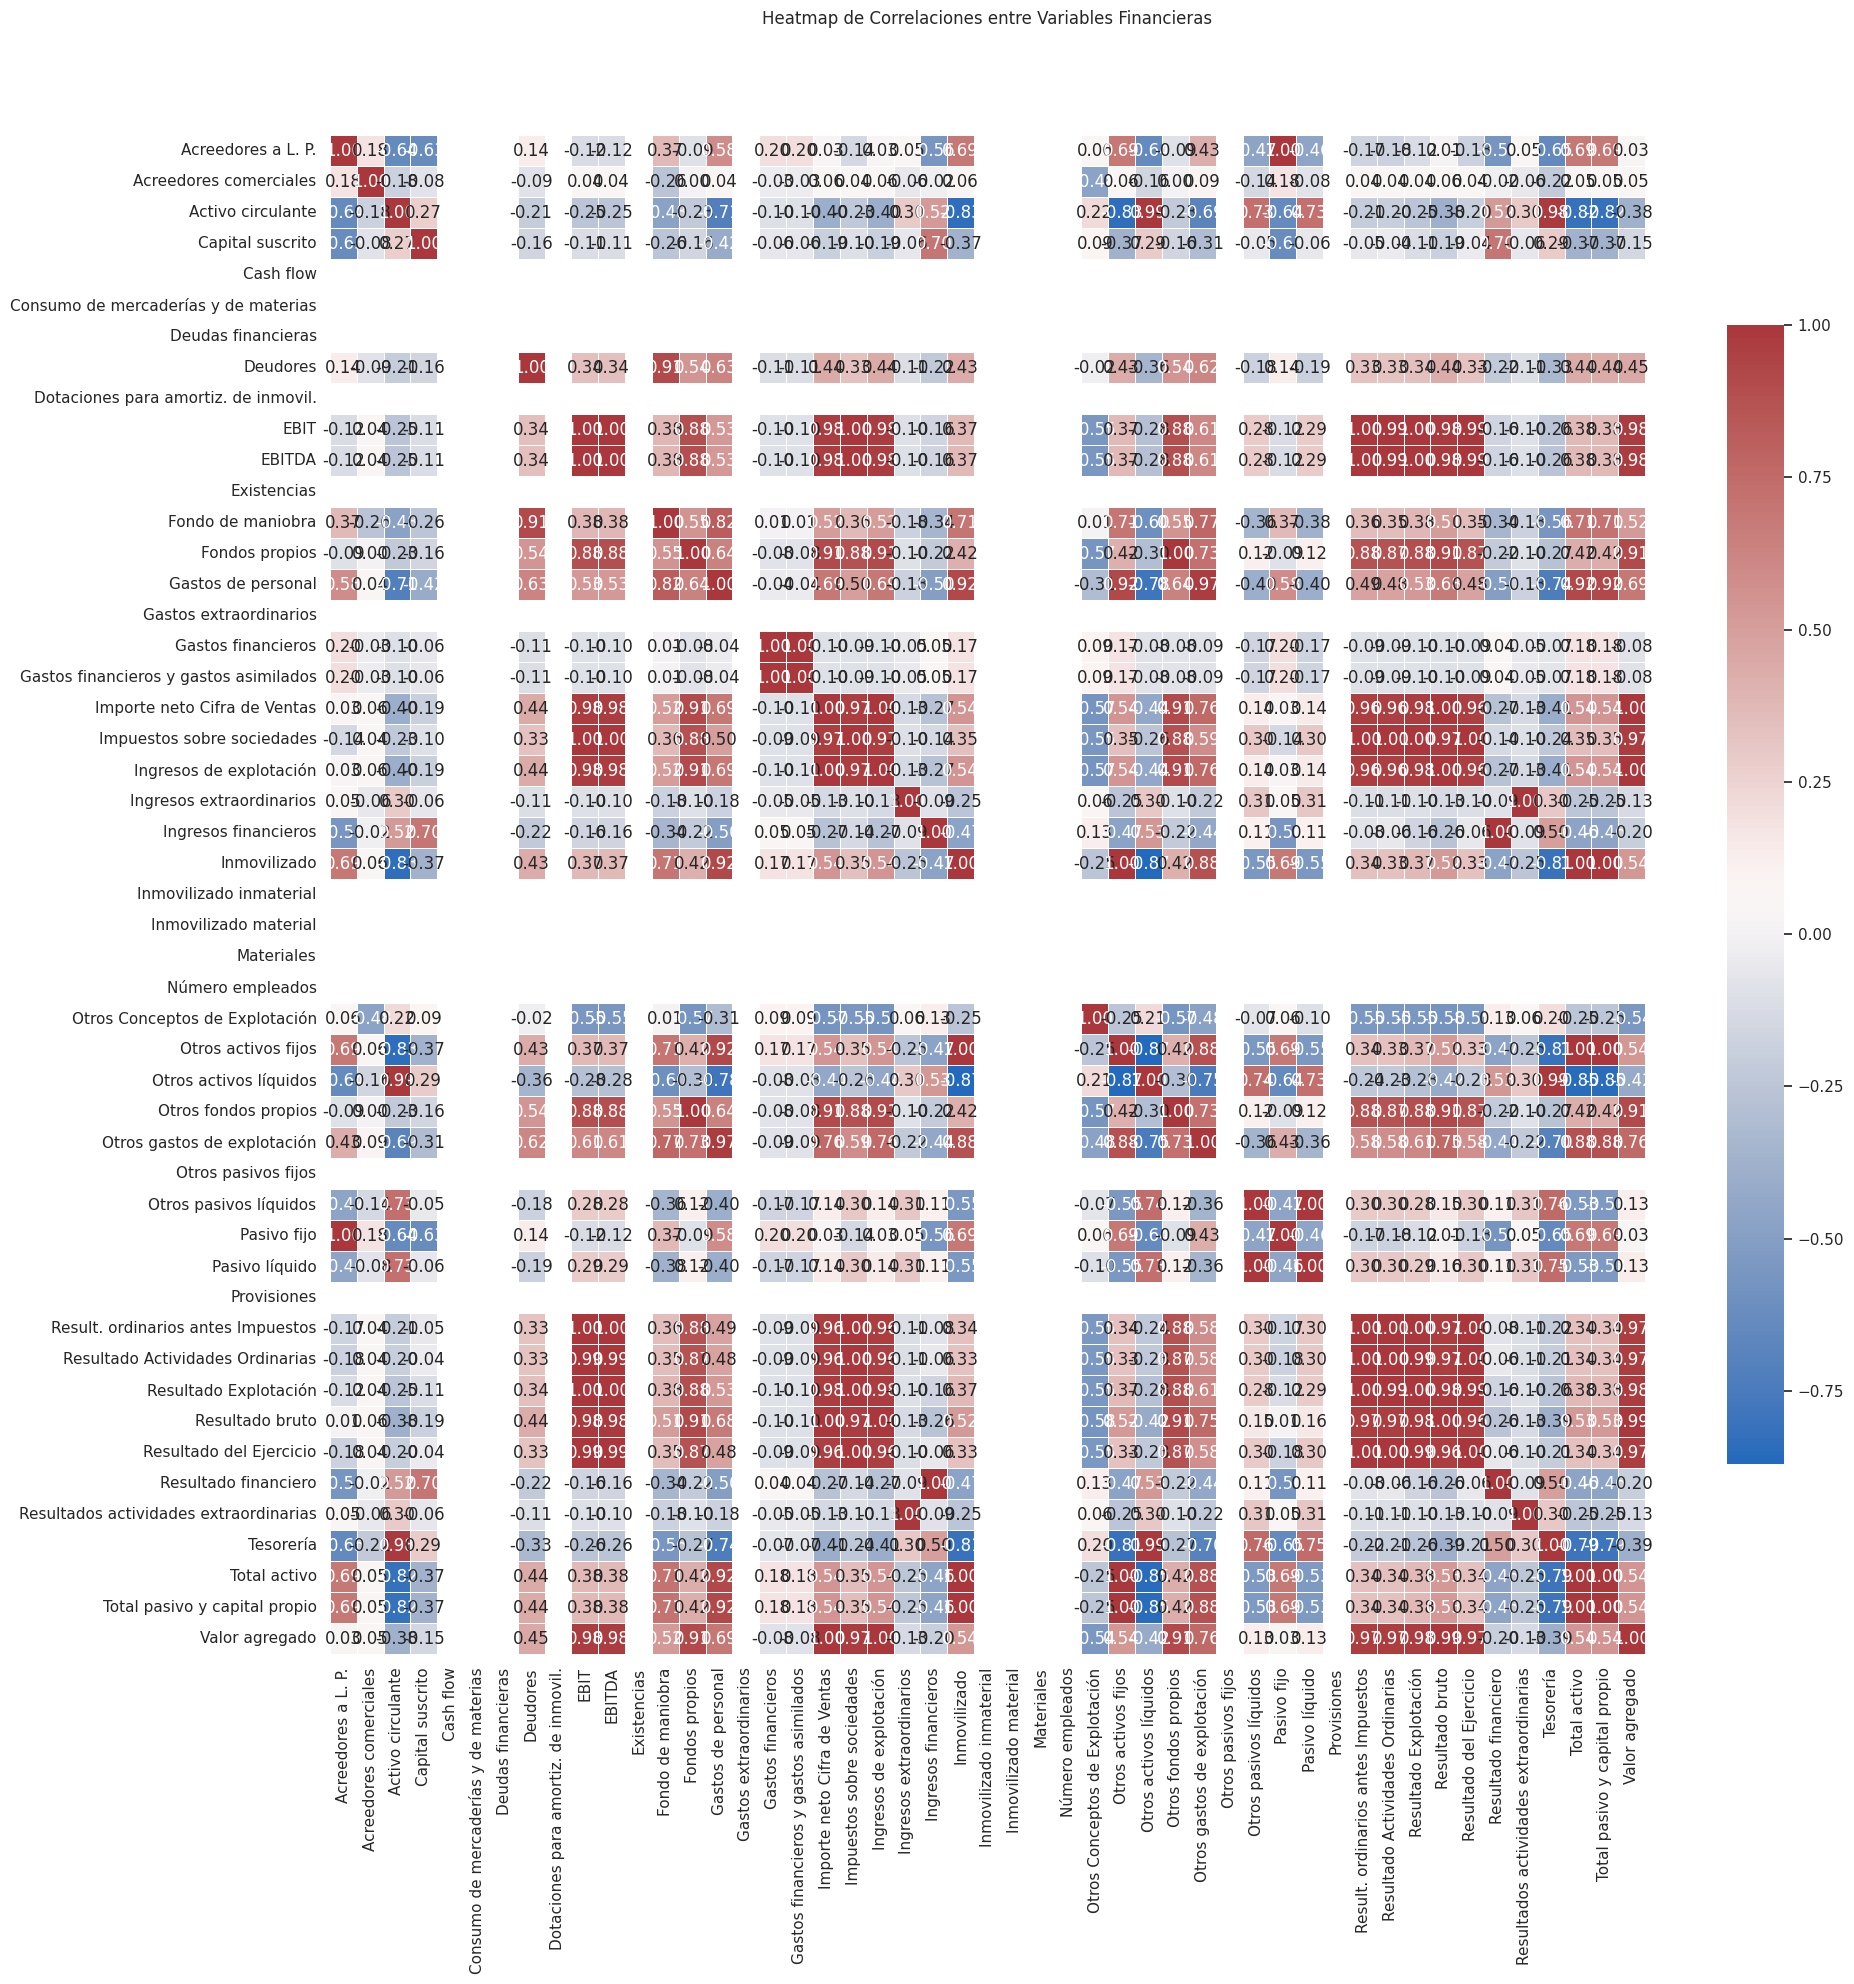

<Figure size 640x480 with 0 Axes>

In [ ]:
# 3. Cálculo de la matriz de correlaciones
corr = df_seleccionadas[numeric_cols].corr()


# 5. Plot del heatmap
plt.figure(figsize=(20,20))
sns.set_theme(style="white")

sns.heatmap(
    corr,
    cmap='vlag',          # Diverging colormap
    annot=True,           # Muestra los coeficientes
    fmt=".2f",            # Formato de los números
    linewidths=0.5,       # Líneas divisorias
    cbar_kws={"shrink": .75}  # Tamaño de la barra de color
)

plt.title('Heatmap de Correlaciones entre Variables Financieras', pad=80)
plt.tight_layout()
plt.show()


#### NEW Heat map after feature selection

Dropped columns: ['Ingresos de explotación', 'EBIT', 'Resultado Explotación', 'Resultado Actividades Ordinarias', 'Total pasivo y capital propio', 'Otros fondos propios', 'Valor agregado', 'Pasivo fijo', 'Gastos financieros y gastos asimilados', 'Resultado bruto', 'Resultados actividades extraordinarias', 'Otros activos líquidos', 'Otros pasivos líquidos', 'Result. ordinarios antes Impuestos', 'Impuestos sobre sociedades', 'Otros activos fijos', 'Resultado del Ejercicio', 'Resultado financiero', 'Total activo']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53975 entries, 0 to 53974
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Año                                   53975 non-null  object 
 1   Acreedores a L. P.                    53975 non-null  float64
 2   Acreedores comerciales                53975 non-null  float64
 3   Activo circulante                 

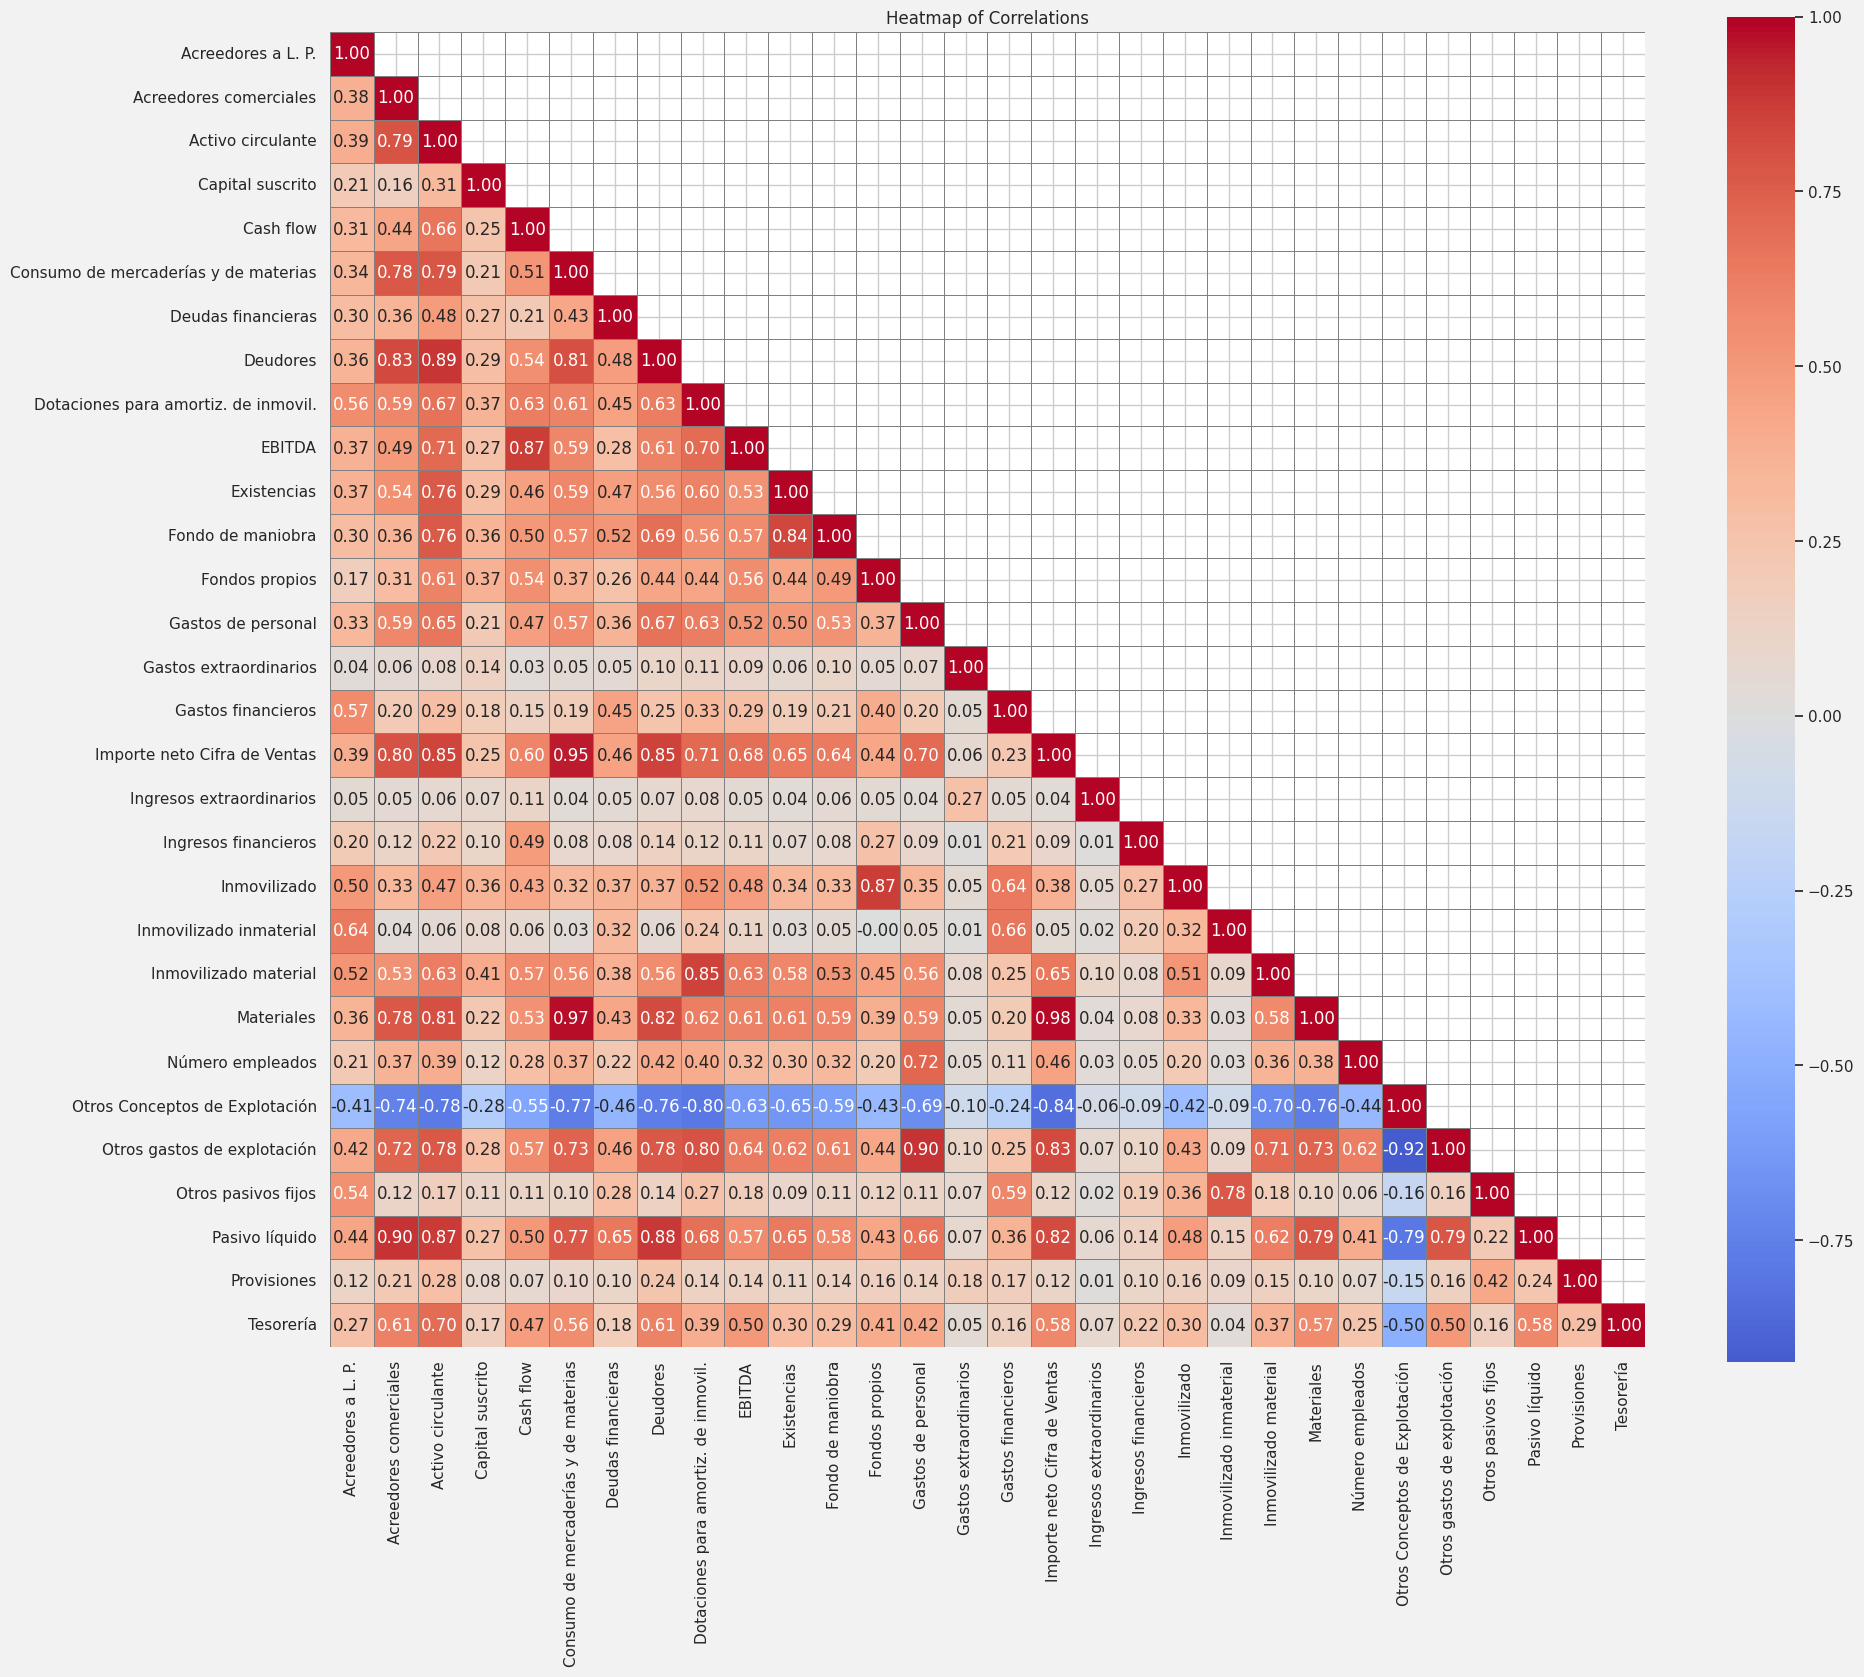

In [ ]:
#Some of them might be computed by the algebraic operation of the others, because it is a profit and loss account.

cols_to_drop = [
    # Sales / operational revenue
    "Ingresos de explotación",

    # Redundant profitability metrics
    "EBIT",
    "Resultado Explotación",
    "Resultado Actividades Ordinarias",

    # Balance sheet totals
    "Total pasivo y capital propio",

    # Equity and related items
    "Otros fondos propios",
    "Valor agregado",

    # Debt / liabilities
    "Pasivo fijo",

    # Financial expense lines
    "Gastos financieros y gastos asimilados",

    # Income statement subtotals
    "Resultado bruto",
    "Resultados actividades extraordinarias",

    # Other working capital items
    "Otros activos líquidos",
    "Otros pasivos líquidos",

    # Pre‐tax profit metrics
    "Result. ordinarios antes Impuestos",

    # Tax expense
    "Impuestos sobre sociedades",

    # Fixed asset items
    "Otros activos fijos",

    # Net result and financial result
    "Resultado del Ejercicio",
    "Resultado financiero",

    # Total assets (duplicate of Total liabilities + equity)
    "Total activo"
]

# Filter the list to include only those columns that actually exist in df
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

if existing_cols_to_drop:
    # Drop the redundant columns and create a reduced DataFrame
    df_reduced = df.drop(columns=existing_cols_to_drop)
    print(f"Dropped columns: {existing_cols_to_drop}")
else:
    # If none of the specified columns are present, make a copy of the original
    df_reduced = df.copy()
    print("No specified columns were found to drop.")
df_reduced.info() # We see that we have 50 features.

df = df_reduced

# 1. Asegurar que sólo se usan columnas numéricas y eliminar columnas vacías
df_seleccionadas = df.drop(columns=['Empresa', 'Año'])
# 2. Calcular la matriz de correlaciones con al menos dos pares de valores válidos
corr = df_seleccionadas.corr()

# 3. Generar máscara triangular superior sin diagonal (para mostrarla)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# 4. Configurar estilo y paleta
plt.figure(figsize=(20, 20), facecolor='#f2f2f2')  # Fondo de figura gris claro
sns.set_style('whitegrid')  # Rejilla ligera

# 5. Dibujar heatmap
sns.heatmap(
    corr,
    mask=mask,             # Ocultar sólo la parte superior estricta
    cmap='coolwarm',       # Paleta sin blancos puros
    center=0,              # Centrar divergencia en 0
    annot=True,            # Mostrar coeficientes numéricos
    fmt='.2f',             # Formato de números con 2 decimales
    linewidths=0.5,        # Líneas divisorias
    linecolor='gray',      # Color de líneas divisorias
    square=True,           # Celdas cuadradas
    cbar_kws={"shrink": .75}  # Tamaño de la barra de color
)

plt.title('Heatmap of Correlations')
plt.tight_layout()
plt.show()



### Time-features plots

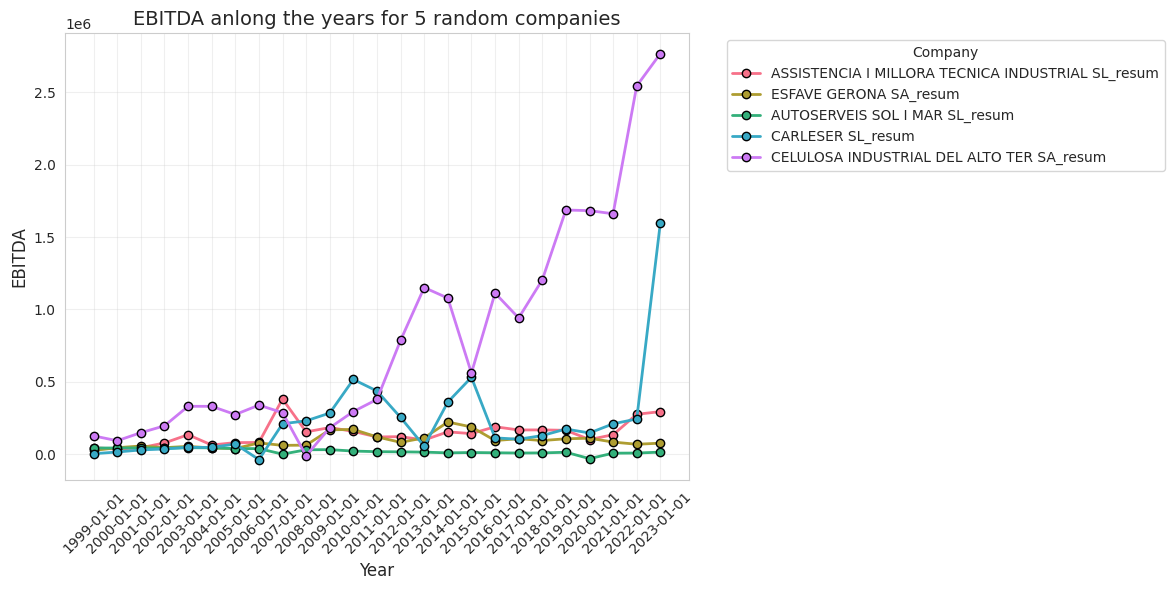

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar datos
df2 = pd.read_csv('/content/drive/MyDrive/Q2_Pattern_Recognition/final_project/data/all_data.csv', sep=',', decimal='.')

# 2. Seleccionar 5 empresas aleatorias
np.random.seed(4)  # Para reproducibilidad
todas_empresas = df2['Empresa'].dropna().unique()
empresas_aleatorias = np.random.choice(todas_empresas, size=5, replace=False)

# 3. Filtrar datos solo para EBITDA de las empresas seleccionadas
df_filtrado = df2[df2['Empresa'].isin(empresas_aleatorias)][['Empresa', 'Año', 'EBITDA']]

# 4. Definir paleta de colores (evitar blanco)
palette = sns.color_palette('husl', len(empresas_aleatorias))

# 5. Crear gráfico de líneas para cada empresa
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
for i, empresa in enumerate(empresas_aleatorias):
    sub = df_filtrado[df_filtrado['Empresa'] == empresa].sort_values('Año')
    color = palette[i]
    plt.plot(
        sub['Año'], sub['EBITDA'],
        marker='o', linestyle='-', linewidth=2, markersize=6,
        label=empresa, color=color,
        markerfacecolor=color, markeredgecolor='black'
    )

# 6. Personalizar gráfica
plt.title('EBITDA anlong the years for 5 random companies', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('EBITDA', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(sorted(df2['Año'].unique()), rotation=45)
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Model 1 and 2: SVR and RFR

Dropped columns: ['Ingresos de explotación', 'EBIT', 'Resultado Explotación', 'Resultado Actividades Ordinarias', 'Total pasivo y capital propio', 'Otros fondos propios', 'Valor agregado', 'Pasivo fijo', 'Gastos financieros y gastos asimilados', 'Resultado bruto', 'Resultados actividades extraordinarias', 'Otros activos líquidos', 'Otros pasivos líquidos', 'Result. ordinarios antes Impuestos', 'Impuestos sobre sociedades', 'Otros activos fijos', 'Resultado del Ejercicio', 'Resultado financiero', 'Total activo']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53975 entries, 0 to 53974
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Año                                   53975 non-null  object 
 1   Acreedores a L. P.                    53975 non-null  float64
 2   Acreedores comerciales                53975 non-null  float64
 3   Activo circulante                 

<ipython-input-10-77f6a72329e3>:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.index = pd.date_range(start = df.index[0][:4], periods = len(df), freq = 'Y')
<ipython-input-10-77f6a72329e3>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Año', 'Empresa'], axis = 1,inplace = True)
<ipython-input-10-77f6a72329e3>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'EBITDA_lag{lag}'] = df['EBITDA'].shift(lag)
<ipython-input-10-77f6a72329e3>:80: SettingWithCopyWarning: 
A value is trying to be 

RandomForestRegressor(max_depth=4, random_state=0)
[0.58691882 0.71885913 0.51633478 0.53512955 0.68325139]
31398.462691886874


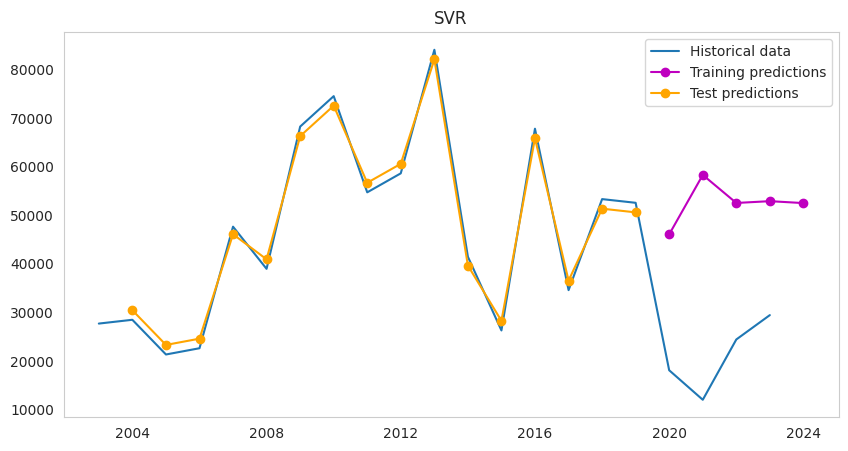

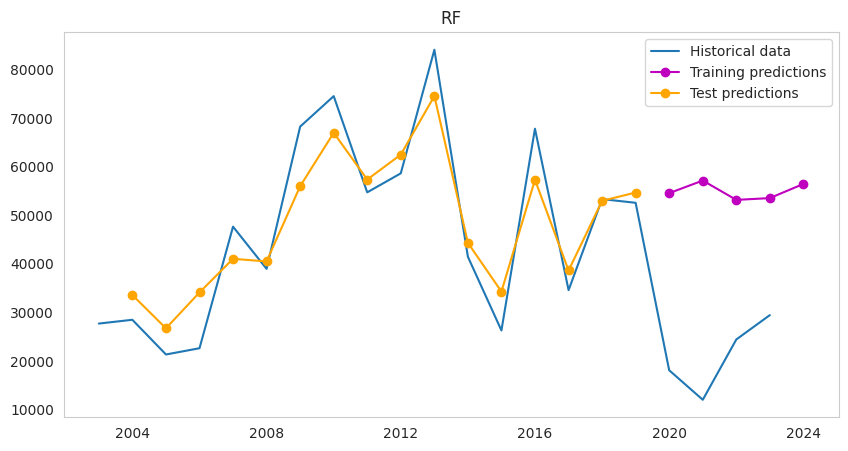

In [ ]:
# === 2. Create DataFrame with 3 random features ===

# Cal arrossegar el folder final_project al teu MyDrive
DF = pd.read_csv('/content/drive/MyDrive/Q2_Pattern_Recognition/final_project/data/all_data.csv', sep=',', decimal='.')#This data is already cleaned (it does not have repeated values or Nan/n.d. values)
DF.head(5)

cols_to_drop = [
    # Sales / operational revenue
    "Ingresos de explotación",

    # Redundant profitability metrics
    "EBIT",
    "Resultado Explotación",
    "Resultado Actividades Ordinarias",

    # Balance sheet totals
    "Total pasivo y capital propio",

    # Equity and related items
    "Otros fondos propios",
    "Valor agregado",

    # Debt / liabilities
    "Pasivo fijo",

    # Financial expense lines
    "Gastos financieros y gastos asimilados",

    # Income statement subtotals
    "Resultado bruto",
    "Resultados actividades extraordinarias",

    # Other working capital items
    "Otros activos líquidos",
    "Otros pasivos líquidos",

    # Pre‐tax profit metrics
    "Result. ordinarios antes Impuestos",

    # Tax expense
    "Impuestos sobre sociedades",

    # Fixed asset items
    "Otros activos fijos",

    # Net result and financial result
    "Resultado del Ejercicio",
    "Resultado financiero",

    # Total assets (duplicate of Total liabilities + equity)
    "Total activo"
]

# Filter the list to include only those columns that actually exist in df
existing_cols_to_drop = [col for col in cols_to_drop if col in DF.columns]

if existing_cols_to_drop:
    # Drop the redundant columns and create a reduced DataFrame
    df_reduced = DF.drop(columns=existing_cols_to_drop)
    print(f"Dropped columns: {existing_cols_to_drop}")
else:
    # If none of the specified columns are present, make a copy of the original
    df_reduced = df.copy()
    print("No specified columns were found to drop.")
df_reduced.info() # We see that we have 50 features.

DF = df_reduced

I = np.random.randint(len(DF['Empresa'].unique()))
empresa = DF['Empresa'].unique()[I]
df = DF[DF['Empresa'] == empresa]
df.index = df['Año']
df.index = pd.date_range(start = df.index[0][:4], periods = len(df), freq = 'Y')
df.drop(['Año', 'Empresa'], axis = 1,inplace = True)


# === 3. Lag features from target ===
N_LAGS = 3
for lag in range(1, N_LAGS + 1):
    df[f'EBITDA_lag{lag}'] = df['EBITDA'].shift(lag)

# === 4. Shift target for next year prediction ===
df['EBITDA_next'] = df['EBITDA'].shift(-1)
df.dropna(inplace=True)

# === 5. Features and target ===


X = df.drop('EBITDA_next', axis = 1).values
y = df['EBITDA_next'].values


# === 6. Scale ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# === 7. Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# === 8. Train model ===
scores = dict.fromkeys(['SVR', 'RF'])

ms = ['SVR', 'RF']
for m in ms:
  if m == 'SVR':
    model = SVR(kernel='rbf', C=100, epsilon=0.1)
    model.fit(X_train, y_train)

  else:
    model = RandomForestRegressor(max_depth=4, random_state=0)
    model.fit(X_train, y_train)


  print(model)
  plt.figure(figsize = (10,5))
  # === 9. Predictions on test set ===
  y_pred_test_scaled = model.predict(X_test)
  print(y_pred_test_scaled)
  y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()
  y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

  y_pred_train_scaled = model.predict(X_train)
  y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
  y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()

  SMSE = np.sqrt(mean_squared_error(y_pred_test, y_test_orig))
  scores[m] = SMSE
  print(SMSE)

  plt.plot(df.index, df['EBITDA'], label = 'Historical data')
  plt.plot(df.index[int(0.8*len(df)):] + pd.DateOffset(years = 1), y_pred_test, color = 'm', marker = 'o', label = 'Training predictions')
  plt.plot(df.index[:int(0.8*len(df))] + pd.DateOffset(years = 1), y_pred_train, color = 'orange', marker = 'o', label = 'Test predictions')
  plt.grid()

  plt.title(m)
  plt.legend()

# Model 3: LSTM

In [ ]:
def prepare_data(data, n_past, n_future, tt_split, val_split):

  x_data, y_data = [], []
  data_days = []


  # Scale the data
  sc = MinMaxScaler(feature_range = (0,1))
  data_scaled = sc.fit_transform(data.reshape(-1,1))


  """
  Create a sequence of sequences:
  - For example:
    x_data = [[1,2,3], [2,3,4], [3,4,5], ...]
    y_data = [4,5,6]
  """

  for i in range(n_past, len(data) - n_future + 1):
    x_data.append(data_scaled[i - n_past:i])
    y_data.append(data_scaled[i])
    data_days.append(list(range(i-n_past, i)))



  x_data = np.array(x_data)
  x_data = x_data.reshape(x_data.shape[0], x_data.shape[1], 1)
  y_data = np.array(y_data).reshape(-1,1)


  split_train_test = int(round(tt_split*len(x_data)))
  split_train_val = int(round(split_train_test*(1-val_split)))

  x_train = x_data[:split_train_test]
  y_train = y_data[:split_train_test]
  data_days_train = data_days[:split_train_test]

  x_test = x_data[split_train_test:]
  y_test = y_data[split_train_test:]
  data_days_test = data_days[split_train_test:]

  x_val = x_data[split_train_val:split_train_test]
  y_val = y_data[split_train_val:split_train_test]
  data_days_val = data_days[split_train_val:split_train_test]


  return x_train, y_train, x_test, y_test, x_val, y_val, sc, data_days_train, data_days_test, data_days_val

x_train, y_train, x_test, y_test, x_val, y_val, sc, data_days_train, data_days_test, data_days_val = prepare_data(df['EBITDA'].values, n_past = 5, n_future = 1, tt_split = 0.8, val_split = 0)

In [ ]:
data_days_train, data_days_test

([[0, 1, 2, 3, 4],
  [1, 2, 3, 4, 5],
  [2, 3, 4, 5, 6],
  [3, 4, 5, 6, 7],
  [4, 5, 6, 7, 8],
  [5, 6, 7, 8, 9],
  [6, 7, 8, 9, 10],
  [7, 8, 9, 10, 11],
  [8, 9, 10, 11, 12],
  [9, 10, 11, 12, 13],
  [10, 11, 12, 13, 14],
  [11, 12, 13, 14, 15],
  [12, 13, 14, 15, 16]],
 [[13, 14, 15, 16, 17], [14, 15, 16, 17, 18], [15, 16, 17, 18, 19]])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 5, 128)         │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 16)          │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,281 (317.50 KB)

 Trainable params: 81,281 (317.50 KB)

 Non-trainable params: 0 (0.00 B)

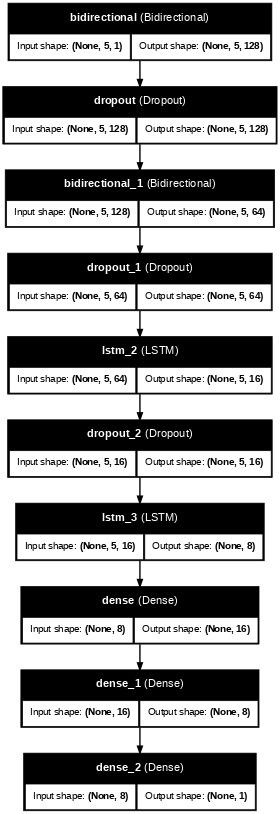

<Figure size 1000x500 with 0 Axes>

In [ ]:
regressor = Sequential()

regressor.add(keras.layers.Input(shape = (x_train.shape[1], x_train.shape[2])))
regressor.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
regressor.add(Dropout(0.2))

# Additional LSTM layers
regressor.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 16, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 8, return_sequences = False))

# Dense layers
regressor.add(Dense(units = 16, activation='relu'))
regressor.add(Dense(units = 8, activation='relu'))

# Output layer
regressor.add(Dense(units = 1, activation='linear'))

# Compile model
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

regressor.summary()

plt.figure(figsize = (10,5))
plot_model(regressor, show_shapes = True, show_layer_names=True, dpi = 50)

In [ ]:
regressor = Sequential()

regressor.add(keras.layers.Input(shape = (x_train.shape[1], x_train.shape[2])))
regressor.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units = 16, return_sequences = False)))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units = 1, activation='linear'))

# Compile model
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 5, 128)         │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 5, 64)          │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,409 (333.63 KB)

 Trainable params: 85,409 (333.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
'''

history = regressor.fit(x_train, y_train, validation_split = 0.3, epochs = 30, batch_size = 2000)
# callbacks = [es])

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4867 - root_mean_squared_error: 0.6976 - val_loss: 0.1845 - val_root_mean_squared_error: 0.4295
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4530 - root_mean_squared_error: 0.6731 - val_loss: 0.1623 - val_root_mean_squared_error: 0.4028
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4088 - root_mean_squared_error: 0.6394 - val_loss: 0.1421 - val_root_mean_squared_error: 0.3769
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3718 - root_mean_squared_error: 0.6098 - val_loss: 0.1233 - val_root_mean_squared_error: 0.3512
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.3360 - root_mean_squared_error: 0.5796 - val_loss: 0.1059 - val_root_mean_squared_error: 0.3255
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2988 - root_mean_squared_error: 0.5467 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2996
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2792 - root

Text(0.5, 0, 'Model')

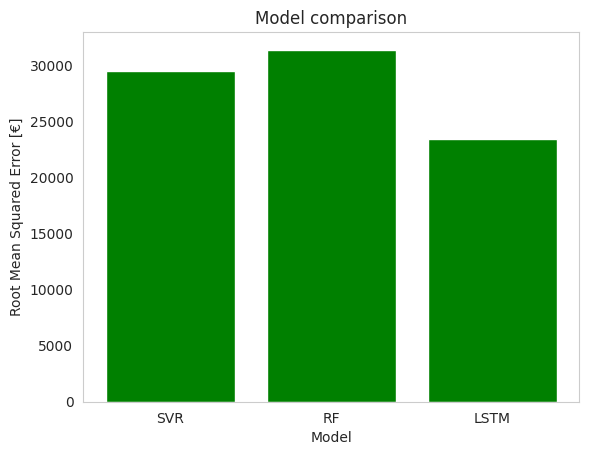

In [ ]:
y_pred_test = regressor(x_test)
y_pred_test_normal = sc.inverse_transform(y_pred_test)
scores['LSTM'] = np.sqrt(mean_squared_error(y_pred_test_normal, sc.inverse_transform(y_test)))

plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(x = scores.keys(), height = scores.values(), color = 'green')
plt.title('Model comparison')
plt.ylabel('Root Mean Squared Error [€]')
plt.xlabel('Model')

<ipython-input-17-bedceb78ce12>:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(start = df.index[-1] + pd.DateOffset(years = 1) , periods = num_future, freq = 'Y'), sc.inverse_transform(predictions.reshape(-1,1)), 'red',marker = 'o', label = 'LSTM Forecast')


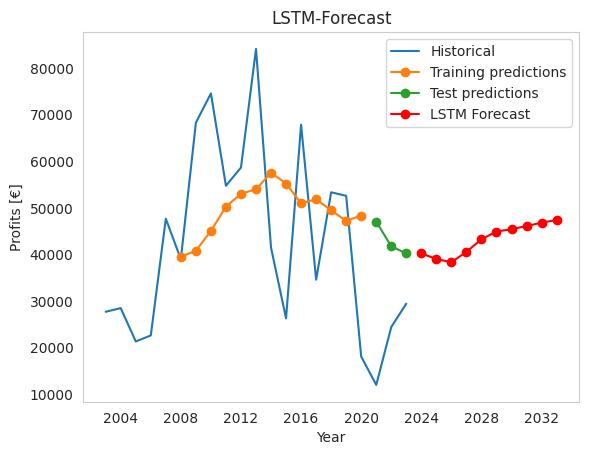

In [ ]:
def plot_results(regressor, num_future, model_name, sc):

  predictions = []
  current_input = x_test[-1]

  for _ in range(num_future):
    next_prediction = regressor.predict(current_input.reshape(1,-1), verbose = 0)
    predictions.append(next_prediction)

    current_input = np.append(current_input[1:], next_prediction)

  predictions = np.squeeze(np.array(predictions))


  y_pred_train = regressor(x_train)
  y_pred_train_normal = sc.inverse_transform(y_pred_train)

  plt.plot(df['EBITDA'], label = 'Historical')
  y_train_preds = regressor(x_train)
  y_train_preds_orig = sc.inverse_transform(y_train_preds)
  plt.plot(df.index[len(x_train[0]):len(x_train[0]) + len(x_train)], y_train_preds_orig, marker = 'o', label = 'Training predictions')

  y_test_preds = regressor(x_test)
  y_test_preds_orig = sc.inverse_transform(y_test_preds)
  plt.plot(df.index[-len(x_test):], y_test_preds_orig, marker = 'o', label = 'Test predictions')

  plt.legend()

  plt.plot(pd.date_range(start = df.index[-1] + pd.DateOffset(years = 1) , periods = num_future, freq = 'Y'), sc.inverse_transform(predictions.reshape(-1,1)), 'red',marker = 'o', label = 'LSTM Forecast')

  plt.grid()
  plt.xlabel('Year')
  plt.ylabel('Profits [€]')
  plt.legend()

  plt.title(model_name+'-Forecast')
  return predictions

model_name = 'LSTM'
num_future = 10
predictions = plot_results(regressor, num_future, 'LSTM', sc)


<ipython-input-17-bedceb78ce12>:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(start = df.index[-1] + pd.DateOffset(years = 1) , periods = num_future, freq = 'Y'), sc.inverse_transform(predictions.reshape(-1,1)), 'red',marker = 'o', label = 'LSTM Forecast')


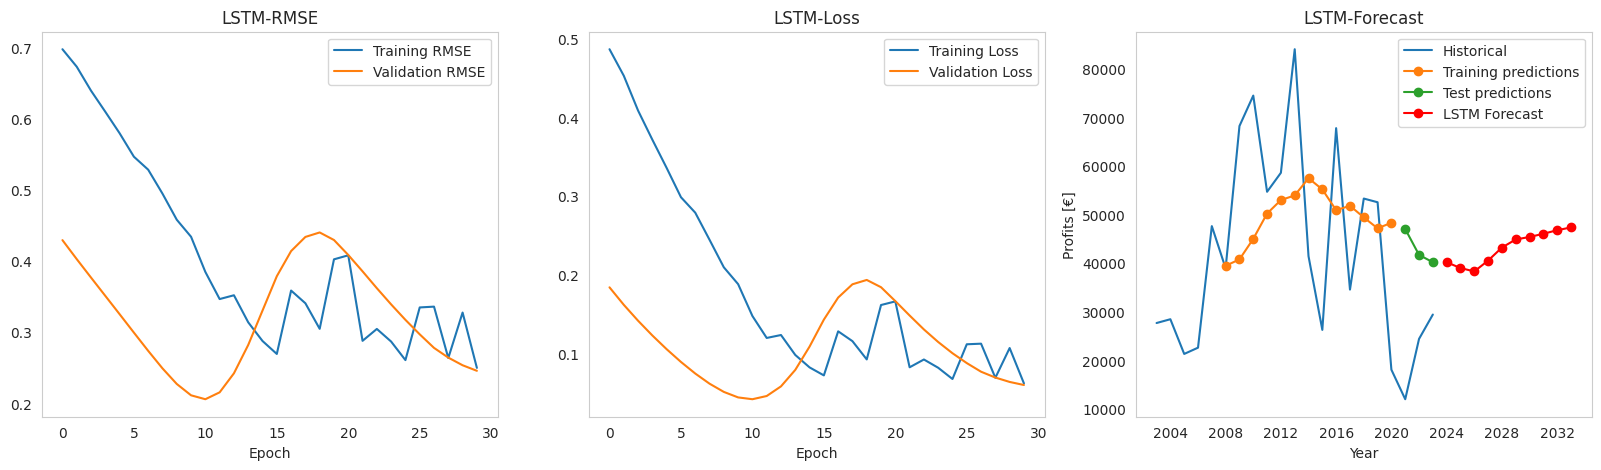

In [ ]:
def plot_data(history, regressor, model_name, sc):

  plt.figure(figsize = (20,5))

  plt.subplot(1,3,1)
  plt.plot(history.epoch, history.history['root_mean_squared_error'], label = 'Training RMSE')
  plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "Validation RMSE")
  plt.legend()
  plt.grid()
  plt.xlabel('Epoch')
  plt.title(model_name + '-RMSE')


  plt.subplot(1,3,2)
  plt.plot(history.epoch, history.history['loss'], label = 'Training Loss')
  plt.plot(history.epoch, history.history['val_loss'], label = "Validation Loss")
  plt.legend()
  plt.xlabel('Epoch')
  plt.grid()
  plt.title(model_name + '-Loss')


  plt.subplot(1,3,3)
  num_future = 10
  plot_results(regressor, num_future, model_name, sc)

plot_data(history, regressor, 'LSTM', sc)

# With all data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Metrics saved to 'results_metrics_200_empresas.csv'


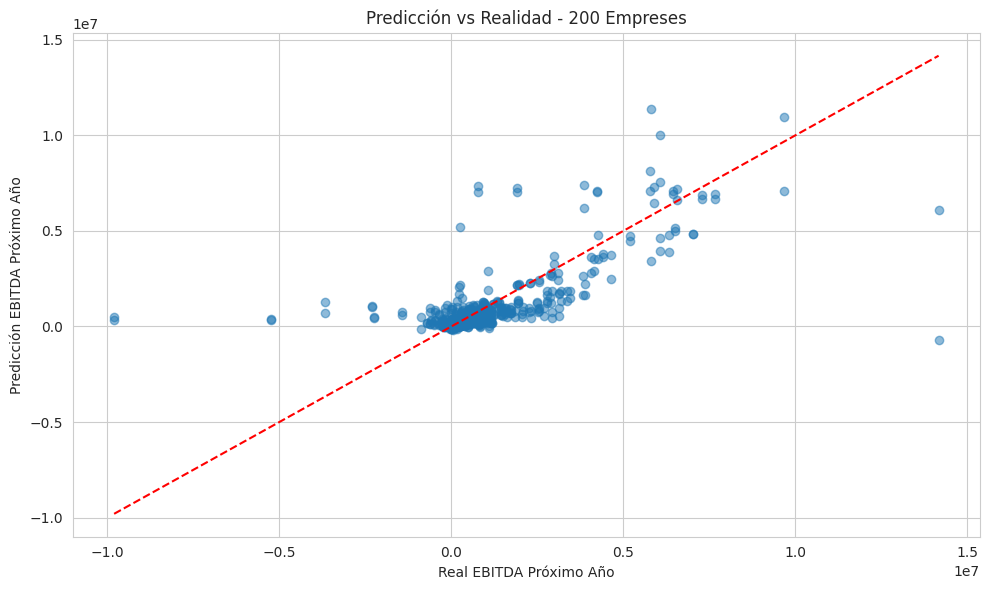

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')

# 1. Load and preprocess data
df_full = pd.read_csv(
    '/content/drive/MyDrive/Q2_Pattern_Recognition/final_project/data/all_data.csv',
    sep=',', decimal='.'
)

# 2. Drop redundant columns
cols_to_drop = [
    "Ingresos de explotación", "EBIT", "Resultado Explotación",
    "Resultado Actividades Ordinarias", "Total pasivo y capital propio",
    "Otros fondos propios", "Valor agregado", "Pasivo fijo",
    "Gastos financieros y gastos asimilados", "Resultado bruto",
    "Resultados actividades extraordinarias", "Otros activos líquidos",
    "Otros pasivos líquidos", "Result. ordinarios antes Impuestos",
    "Impuestos sobre sociedades", "Otros activos fijos",
    "Resultado del Ejercicio", "Resultado financiero", "Total activo"
]
df_full.drop(columns=[c for c in cols_to_drop if c in df_full.columns], inplace=True)

# 3. Prepare storage for metrics and predictions
df_metrics = []
all_true = []
all_pred = []

# 4. Sample 200 random companies
np.random.seed(42)
companies = df_full['Empresa'].dropna().unique()
sample_companies = np.random.choice(companies, size=200, replace=False)

# 5. Loop through each company
for comp in sample_companies:
    df = df_full[df_full['Empresa'] == comp].copy()
    # Ensure datetime index using only the year component
    years = df['Año'].astype(str).str[:4]  # handle full-date strings by slicing
    df.index = pd.to_datetime(years + '-12-31', format='%Y-%m-%d')
    df.drop(['Año', 'Empresa'], axis=1, inplace=True)

    # Create lag features
    N_LAGS = 3
    for lag in range(1, N_LAGS + 1):
        df[f'EBITDA_lag{lag}'] = df['EBITDA'].shift(lag)
    df['EBITDA_next'] = df['EBITDA'].shift(-1)
    df.dropna(inplace=True)
    if df.empty:
        continue

    # Features and target
    X = df.drop('EBITDA_next', axis=1).values
    y = df['EBITDA_next'].values

    # Scale features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y.reshape(-1,1)).ravel()

    # Train/test split (80/20, no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(
        Xs, ys, test_size=0.2, shuffle=False
    )
    if len(y_test) == 0:
        continue

    # Train and evaluate models
    models = {
        'SVR': SVR(kernel='rbf', C=100, epsilon=0.1),
        'RF': RandomForestRegressor(max_depth=4, random_state=0)
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
        # Predict and inverse scale
        y_pred_scaled = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
        y_true = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        df_metrics.append({
            'Empresa': comp,
            'Model': name,
            'RMSE': rmse,
            'MAE': mae
        })

        # Accumulate for global plot
        all_true.extend(y_true)
        all_pred.extend(y_pred)

# 6. Save metrics to CSV
metrics_df = pd.DataFrame(df_metrics)
metrics_df.to_csv('results_metrics_200_empresas.csv', index=False)
print("Metrics saved to 'results_metrics_200_empresas.csv'")

# 7. Plot Predicción vs Realidad for all companies
plt.figure(figsize=(10, 6))
plt.scatter(all_true, all_pred, alpha=0.5)
min_val = min(min(all_true), min(all_pred))
max_val = max(max(all_true), max(all_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Real EBITDA Próximo Año')
plt.ylabel('Predicción EBITDA Próximo Año')
plt.title('Predicción vs Realidad - 200 Empreses')
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
print(metrics_df)



                                       Empresa Model           RMSE  \
0                  TRANSPORTS PADROSA SA_resum   SVR  151075.128279   
1                  TRANSPORTS PADROSA SA_resum    RF   90623.358551   
2                    EMBOTITS LAPEDRA SL_resum   SVR   23531.257136   
3                    EMBOTITS LAPEDRA SL_resum    RF   28385.118266   
4    TRANSPORTS I EXCAVACIONS J PLAJA SL_resum   SVR   53575.518077   
..                                         ...   ...            ...   
395                     RADIO RIPOLL, SL_resum    RF    5079.820090   
396  PROMOCIONS IMMOBILIARIES TALAIXA SL_resum   SVR   24406.137026   
397  PROMOCIONS IMMOBILIARIES TALAIXA SL_resum    RF   42820.528219   
398        PLASTICOS COMERCIAL FERRER SA_resum   SVR    3190.145834   
399        PLASTICOS COMERCIAL FERRER SA_resum    RF    3869.499656   

               MAE  
0    142238.952826  
1     83424.619975  
2     21379.124158  
3     26804.937989  
4     47626.947848  
..             ...  


Mounted at /content/drive
SVR/RF [1/20] - Empresa: TRANSPORTS PADROSA SA_resum
SVR/RF [2/20] - Empresa: EMBOTITS LAPEDRA SL_resum
SVR/RF [3/20] - Empresa: TRANSPORTS I EXCAVACIONS J PLAJA SL_resum
SVR/RF [4/20] - Empresa: IMMOBLES 54 SL_resum
SVR/RF [5/20] - Empresa: FERRETERIA FRANUR SL_resum
SVR/RF [6/20] - Empresa: REPRESENTACIONS I DISTRIBUCIONS TRAYTER SL_resum
SVR/RF [7/20] - Empresa: PORTANALS SL_resum
SVR/RF [8/20] - Empresa: PROVEIMENTS D'AIGUA SA_resum
SVR/RF [9/20] - Empresa: GARAJE SALA SA_resum
SVR/RF [10/20] - Empresa: YANNI 54 SL_resum
SVR/RF [11/20] - Empresa: EMBUTIDOS Y JAMONES OLOT SL_resum
SVR/RF [12/20] - Empresa: TECFUSTA SL_resum
SVR/RF [13/20] - Empresa: ARIDOS HERMANOS CURANTA SA_resum
SVR/RF [14/20] - Empresa: INSTAL LACIONS CALELLA SL_resum
SVR/RF [15/20] - Empresa: CURTIDOS J POMES SA_resum
SVR/RF [16/20] - Empresa: ASSET GESTIO SOCIEDAD LIMITADA_resum
SVR/RF [17/20] - Empresa: AGRICAMP SL_resum
SVR/RF [18/20] - Empresa: PISCINAS BLANES SL_resum
SVR/RF [19/2

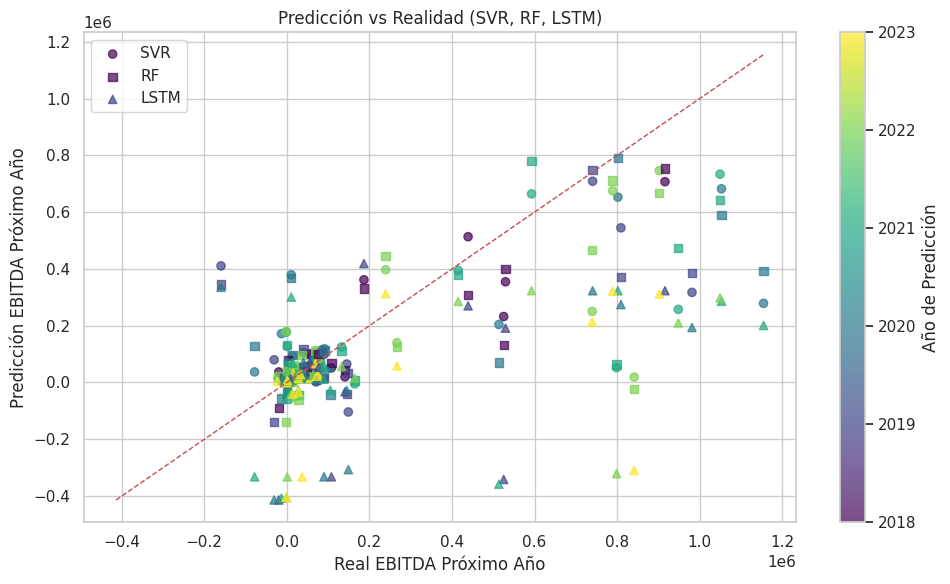

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# === Global settings ===
N_SAMPLE = 20
N_LAGS = 3
np.random.seed(42)

# === Load and preprocess full data ===
df_full = pd.read_csv(
    '/content/drive/MyDrive/final_project/data/all_data.csv', sep=',', decimal='.'
)
cols_to_drop = [
    "Ingresos de explotación", "EBIT", "Resultado Explotación",
    "Resultado Actividades Ordinarias", "Total pasivo y capital propio",
    "Otros fondos propios", "Valor agregado", "Pasivo fijo",
    "Gastos financieros y gastos asimilados", "Resultado bruto",
    "Resultados actividades extraordinarias", "Otros activos líquidos",
    "Otros pasivos líquidos", "Result. ordinarios antes Impuestos",
    "Impuestos sobre sociedades", "Otros activos fijos",
    "Resultado del Ejercicio", "Resultado financiero", "Total activo"
]
df_full.drop(columns=[c for c in cols_to_drop if c in df_full.columns], inplace=True)

# Helper to set datetime index
def set_year_index(df):
    years = df['Año'].astype(str).str[:4]
    return pd.to_datetime(years + '-12-31', format='%Y-%m-%d')

# Prepare companies sample
df_full.dropna(subset=['Empresa'], inplace=True)
companies = df_full['Empresa'].unique()
sample_comps = np.random.choice(companies, size=N_SAMPLE, replace=False)

# Global accumulators
all_true = []
all_pred = []
all_models = []
all_years = []
df_metrics = []  # for SVR/RF metrics

# --- Part 1: SVR & RF ---
for idx, comp in enumerate(sample_comps, start=1):
    print(f"SVR/RF [{idx}/{N_SAMPLE}] - Empresa: {comp}")
    df = df_full[df_full['Empresa']==comp].copy()
    df.index = set_year_index(df)
    df.drop(['Año','Empresa'], axis=1, inplace=True)
    # Create lag features and target
    for lag in range(1, N_LAGS+1):
        df[f'EBITDA_lag{lag}'] = df['EBITDA'].shift(lag)
    df['EBITDA_next'] = df['EBITDA'].shift(-1)
    df.dropna(inplace=True)
    if df.empty:
        continue
    # Prepare data
    X = df.drop('EBITDA_next', axis=1).values
    y = df['EBITDA_next'].values
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y.reshape(-1,1)).ravel()
    split = int(0.8 * len(Xs))
    X_train, X_test = Xs[:split], Xs[split:]
    y_train, y_test = ys[:split], ys[split:]
    if len(y_test) == 0:
        continue
    years_test = df.index[split:].year
    # Evaluation for each model
    for name, model in {
        'SVR': SVR(kernel='rbf', C=200, epsilon=0.1),
        'RF': RandomForestRegressor(max_depth=4, random_state=0)
    }.items():
        model.fit(X_train, y_train)
        y_pred_s = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
        y_true = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()
        df_metrics.append({
            'Empresa': comp,
            'Model': name,
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred)
        })
        all_true.extend(y_true)
        all_pred.extend(y_pred)
        all_models.extend([name] * len(y_pred))
        all_years.extend(years_test)

# Save SVR/RF metrics
pd.DataFrame(df_metrics).to_csv('results_metrics_svrrf_200.csv', index=False)
print('SVR/RF metrics saved to results_metrics_svrrf_200.csv')

# --- Part 2: LSTM ---
def prepare_sequence(data, n_past, train_frac):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.reshape(-1,1))
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(scaled[i-n_past:i])
        y.append(scaled[i])
    X = np.array(X).reshape(-1, n_past, 1)
    y = np.array(y).reshape(-1, 1)
    split = int(train_frac * len(X))
    return X[:split], y[:split], X[split:], y[split:], scaler

metrics_lstm = []
for idx, comp in enumerate(sample_comps, start=1):
    print(f"LSTM [{idx}/{N_SAMPLE}] - Empresa: {comp}")
    df = df_full[df_full['Empresa']==comp].copy()
    df.index = set_year_index(df)
    df.drop(['Año','Empresa'], axis=1, inplace=True)
    data = df['EBITDA'].values
    if len(data) < N_LAGS+1:
        continue
    x_train, y_train, x_test, y_test, scaler = prepare_sequence(data, N_LAGS, 0.8)
    years_test = df.index[N_LAGS:][int(0.8*(len(data)-N_LAGS)):].year
    # Build LSTM
    model = Sequential([
        Input(shape=(x_train.shape[1], 1)),
        Bidirectional(LSTM(64, return_sequences=True)), Dropout(0.2),
        Bidirectional(LSTM(32, return_sequences=True)), Dropout(0.2),
        LSTM(16, return_sequences=True), Dropout(0.2),
        LSTM(8),
        Dense(16, activation='relu'), Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=2000,
              callbacks=callbacks, verbose=0)
    # Predictions
    y_pred_s = model.predict(x_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_s).ravel()
    y_true = scaler.inverse_transform(y_test).ravel()
    metrics_lstm.append({
        'Empresa': comp,
        'Model': 'LSTM',
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    })
    all_true.extend(y_true)
    all_pred.extend(y_pred)
    all_models.extend(['LSTM'] * len(y_pred))
    all_years.extend(years_test)

# Save LSTM metrics
pd.DataFrame(metrics_lstm).to_csv('results_metrics_lstm_200.csv', index=False)
print('LSTM metrics saved to results_metrics_lstm_200.csv')

# --- Global plot: Predicción vs Realidad ---
printfmt = {'SVR': 'o', 'RF': 's', 'LSTM': '^'}
norm = mpl.colors.Normalize(vmin=min(all_years), vmax=max(all_years))
cmap = plt.cm.viridis

plt.figure(figsize=(10, 6))
for m, marker in printfmt.items():
    mask = [mod == m for mod in all_models]
    xs = np.array(all_true)[mask]
    ys = np.array(all_pred)[mask]
    yrs = np.array(all_years)[mask]
    sc = plt.scatter(xs, ys, marker=marker, c=yrs, cmap=cmap, norm=norm,
                     label=m, alpha=0.7)
# Perfect prediction line
minv, maxv = min(all_true + all_pred), max(all_true + all_pred)
plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)
plt.xlabel('Real EBITDA Próximo Año')
plt.ylabel('Predicción EBITDA Próximo Año')
plt.title('Predicción vs Realidad (SVR, RF, LSTM)')
plt.grid(True)
plt.colorbar(sc, label='Año de Predicción')
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# === Global settings ===
N_SAMPLE = 200
N_LAGS = 3
np.random.seed(42)

# === Load and preprocess full data ===
df_full = pd.read_csv(
    '/content/drive/MyDrive/final_project/data/all_data.csv', sep=',', decimal='.'
)
cols_to_drop = [
    "Ingresos de explotación", "EBIT", "Resultado Explotación",
    "Resultado Actividades Ordinarias", "Total pasivo y capital propio",
    "Otros fondos propios", "Valor agregado", "Pasivo fijo",
    "Gastos financieros y gastos asimilados", "Resultado bruto",
    "Resultados actividades extraordinarias", "Otros activos líquidos",
    "Otros pasivos líquidos", "Result. ordinarios antes Impuestos",
    "Impuestos sobre sociedades", "Otros activos fijos",
    "Resultado del Ejercicio", "Resultado financiero", "Total activo"
]
df_full.drop(columns=[c for c in cols_to_drop if c in df_full.columns], inplace=True)

# Helper to set datetime index
def set_year_index(df):
    years = df['Año'].astype(str).str[:4]
    return pd.to_datetime(years + '-12-31', format='%Y-%m-%d')

# Prepare companies sample
df_full.dropna(subset=['Empresa'], inplace=True)
companies = df_full['Empresa'].unique()
sample_comps = np.random.choice(companies, size=N_SAMPLE, replace=False)

# Global accumulators
all_true = []
all_pred = []
all_models = []
all_years = []
df_metrics = []  # for SVR/RF metrics

# --- Part 1: SVR & RF ---
for idx, comp in enumerate(sample_comps, start=1):
    print(f"SVR/RF [{idx}/{N_SAMPLE}] - Empresa: {comp}")
    df = df_full[df_full['Empresa']==comp].copy()
    df.index = set_year_index(df)
    df.drop(['Año','Empresa'], axis=1, inplace=True)
    # Create lag features and target
    for lag in range(1, N_LAGS+1):
        df[f'EBITDA_lag{lag}'] = df['EBITDA'].shift(lag)
    df['EBITDA_next'] = df['EBITDA'].shift(-1)
    df.dropna(inplace=True)
    if df.empty:
        continue
    # Prepare data
    X = df.drop('EBITDA_next', axis=1).values
    y = df['EBITDA_next'].values
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y.reshape(-1,1)).ravel()
    split = int(0.8 * len(Xs))
    X_train, X_test = Xs[:split], Xs[split:]
    y_train, y_test = ys[:split], ys[split:]
    if len(y_test) == 0:
        continue
    years_test = df.index[split:].year
    # Evaluation for each model
    for name, model in {
        'SVR': SVR(kernel='rbf', C=100, epsilon=0.1),
        'RF': RandomForestRegressor(max_depth=4, random_state=0)
    }.items():
        model.fit(X_train, y_train)
        y_pred_s = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
        y_true = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()
        df_metrics.append({
            'Empresa': comp,
            'Model': name,
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred)
        })
        all_true.extend(y_true)
        all_pred.extend(y_pred)
        all_models.extend([name] * len(y_pred))
        all_years.extend(years_test)

# Save SVR/RF metrics
pd.DataFrame(df_metrics).to_csv('results_metrics_svrrf_200.csv', index=False)
print('SVR/RF metrics saved to results_metrics_svrrf_200.csv')

# --- Part 2: LSTM ---
def prepare_sequence(data, n_past, train_frac):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.reshape(-1,1))
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(scaled[i-n_past:i])
        y.append(scaled[i])
    X = np.array(X).reshape(-1, n_past, 1)
    y = np.array(y).reshape(-1, 1)
    split = int(train_frac * len(X))
    return X[:split], y[:split], X[split:], y[split:], scaler

metrics_lstm = []
for idx, comp in enumerate(sample_comps, start=1):
    print(f"LSTM [{idx}/{N_SAMPLE}] - Empresa: {comp}")
    df = df_full[df_full['Empresa']==comp].copy()
    df.index = set_year_index(df)
    df.drop(['Año','Empresa'], axis=1, inplace=True)
    data = df['EBITDA'].values
    if len(data) < N_LAGS+1:
        continue
    x_train, y_train, x_test, y_test, scaler = prepare_sequence(data, N_LAGS, 0.8)
    years_test = df.index[N_LAGS:][int(0.8*(len(data)-N_LAGS)):].year
    # Build LSTM
    model = Sequential([
        Input(shape=(x_train.shape[1], 1)),
        Bidirectional(LSTM(64, return_sequences=True)), Dropout(0.2),
        Bidirectional(LSTM(32, return_sequences=True)), Dropout(0.2),
        LSTM(16, return_sequences=True), Dropout(0.2),
        LSTM(8),
        Dense(16, activation='relu'), Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=2000,
              callbacks=callbacks, verbose=0)
    # Predictions
    y_pred_s = model.predict(x_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_s).ravel()
    y_true = scaler.inverse_transform(y_test).ravel()
    metrics_lstm.append({
        'Empresa': comp,
        'Model': 'LSTM',
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    })
    all_true.extend(y_true)
    all_pred.extend(y_pred)
    all_models.extend(['LSTM'] * len(y_pred))
    all_years.extend(years_test)

# Save LSTM metrics
pd.DataFrame(metrics_lstm).to_csv('results_metrics_lstm_200.csv', index=False)
print('LSTM metrics saved to results_metrics_lstm_200.csv')

# --- Global plot: Predicción vs Realidad ---
printfmt = {'SVR': 'o', 'RF': 's', 'LSTM': '^'}
norm = mpl.colors.Normalize(vmin=min(all_years), vmax=max(all_years))
cmap = plt.cm.viridis

plt.figure(figsize=(10, 6))
for m, marker in printfmt.items():
    mask = [mod == m for mod in all_models]
    xs = np.array(all_true)[mask]
    ys = np.array(all_pred)[mask]
    yrs = np.array(all_years)[mask]
    sc = plt.scatter(xs, ys, marker=marker, c=yrs, cmap=cmap, norm=norm,
                     label=m, alpha=0.7)
# Perfect prediction line
minv, maxv = min(all_true + all_pred), max(all_true + all_pred)
plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)
plt.xlabel('Real EBITDA next year')
plt.ylabel('predict EBITDA next year')
plt.title('predict vs Real (SVR, RF, LSTM)')
plt.grid(True)
plt.colorbar(sc, label='year of Predicción')
plt.legend()
plt.tight_layout()
plt.show()


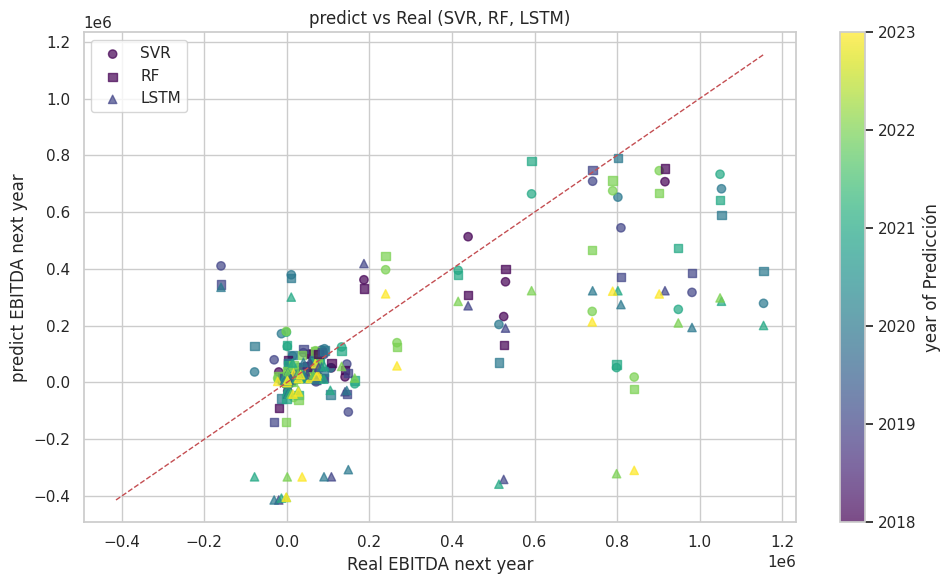

In [ ]:
# --- Global plot: Predicción vs Realidad ---
printfmt = {'SVR': 'o', 'RF': 's', 'LSTM': '^'}
norm = mpl.colors.Normalize(vmin=min(all_years), vmax=max(all_years))
cmap = plt.cm.viridis

plt.figure(figsize=(10, 6))
for m, marker in printfmt.items():
    mask = [mod == m for mod in all_models]
    xs = np.array(all_true)[mask]
    ys = np.array(all_pred)[mask]
    yrs = np.array(all_years)[mask]
    sc = plt.scatter(xs, ys, marker=marker, c=yrs, cmap=cmap, norm=norm,
                     label=m, alpha=0.7)
# Perfect prediction line
minv, maxv = min(all_true + all_pred), max(all_true + all_pred)
plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)
plt.xlabel('Real EBITDA next year')
plt.ylabel('predict EBITDA next year')
plt.title('predict vs Real (SVR, RF, LSTM)')
plt.grid(True)
plt.colorbar(sc, label='year of Predicción')
plt.legend()
plt.tight_layout()
plt.show()
